# FastMRI mask **원본 ↔ 재현** 일치 여부 검증
이 노트북은
1. `brain/knee × acc4/8` 전체 k‑space 파일을 순회하며 mask 를 재생성
2. 원본 mask 와 XOR 비교해 **mismatch 픽셀 수** 를 집계
3. 불일치 사례가 있을 경우 시각화

---
**사용 방법**
1. 아래 `DATA_DIR` 변수만 본인 데이터 경로로 수정.
2. 상단 메뉴 → 런타임 → 모두 실행.
3. Section 4 요약 표에서 mismatch=0 이면 완벽 재현입니다.

In [5]:

import os, re, glob, warnings
import numpy as np, h5py, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from subsample import create_mask_for_mask_type
warnings.filterwarnings("ignore")

# ====== 데이터 경로 수정 ======
DATA_DIR = "/home/swpants05/Desktop/2025_FastMri/Data"
# DATA_DIR = "/path/to/FastMRI/Data"


In [22]:


def load_mask(path):
    with h5py.File(path,'r') as f:
        return f['mask'][()].astype(bool)

def list_files(split):
    if split in ("train","val"):
        return glob.glob(os.path.join(DATA_DIR, split, "kspace", "*.h5"))
    return glob.glob(os.path.join(DATA_DIR, "leaderboard", "acc*", "kspace", "*.h5"))

kspace_paths = sum([list_files(s) for s in ("train","val","leaderboard")], [])
print("총 파일 수:", len(kspace_paths))


총 파일 수: 516


In [29]:
# ---------- 규칙 ----------
KNEE_CENTER = {320:26, 322:26, 338:27, 356:28,
               368:29, 370:31, 372:33, 386:33,
               388:33, 480:39}
BRAIN_CF    = 0.099          # ≈ 33/334

def synth_mask(orig_mask: np.ndarray, body: str, acc: int):
    """
    orig_mask : 1-D bool (len=N)
    returns   : (bool[N], centerW)
    """
    N = orig_mask.shape[-1]

    # --- centerW & cf --------------------------------------------------
    if body == "brain":
        centerW = int(round(BRAIN_CF * N))    # 31 or 33 등
    else:                                     # knee
        centerW = KNEE_CENTER.get(N, int(round(0.08 * N)))
    cf = centerW / N

    # --- offset : ‘center 블록 끝 + acc’ 가 첫 샘플 --------------------
    pad      = (N - centerW + 1) // 2         # subsample.py 와 동일 정의
    offset   = (pad + centerW) % acc          # ⇒ 첫 샘플 = center_end + acc

    # --- MaskFunc 호출 -------------------------------------------------
    shape3d  = (1, N, 1)                      # len==3, shape[-2]==N
    mf       = create_mask_for_mask_type("equispaced", [cf], [acc])
    mask3d , _ = mf(shape3d, offset=offset)

    synth = mask3d.squeeze().cpu().numpy().astype(bool)
    return synth, centerW


In [30]:

rows=[]
for p in tqdm(kspace_paths, desc="compare"):
    fname=os.path.basename(p)
    m=REG.search(fname)
    if m:
        body, acc = m.groups()
    else:
        m=LB_REG.search(fname)
        if not m: continue
        body, = m.groups()
        acc = "4" if "/acc4/" in p else "8"
    acc=int(acc)

    orig = load_mask(p)
    synth, cW = synth_mask(orig, body, acc)   # orig 자체(1-D 배열) 전달
    diff = np.logical_xor(orig, synth)

    rows.append(dict(path=p, body=body, acc=acc,
                     N=orig.shape[-1],
                     centerW_orig=int(orig.sum()),
                     centerW_synth=cW,
                     mismatch=int(diff.sum())))

df = pd.DataFrame(rows)
display(df)


compare:   0%|          | 0/516 [00:00<?, ?it/s]

,path,body,acc,N,centerW_orig,centerW_synth,mismatch
0,/home/swpants05/Desktop/2025_FastMri/Data/trai...,knee,4,368,114,29,170
1,/home/swpants05/Desktop/2025_FastMri/Data/trai...,brain,4,396,123,39,6
2,/home/swpants05/Desktop/2025_FastMri/Data/trai...,brain,8,396,77,39,96
3,/home/swpants05/Desktop/2025_FastMri/Data/trai...,brain,4,396,123,39,6
4,/home/swpants05/Desktop/2025_FastMri/Data/trai...,brain,8,396,77,39,96
...,...,...,...,...,...,...,...
511,/home/swpants05/Desktop/2025_FastMri/Data/lead...,knee,4,368,114,29,170
512,/home/swpants05/Desktop/2025_FastMri/Data/lead...,brain,4,396,123,39,6
513,/home/swpants05/Desktop/2025_FastMri/Data/lead...,knee,4,372,116,33,170
514,/home/swpants05/Desktop/2025_FastMri/Data/lead...,brain,4,392,122,39,6


In [31]:

summary=(df.groupby(['body','acc'])
           .agg({'mismatch':['sum','max'],
                 'centerW_orig':['nunique'],
                 'N':['nunique']}))
print("==== mismatch summary ====")
display(summary)


==== mismatch summary ====


mismatch      centerW_orig       N
               sum  max      nunique nunique
body  acc                                   
brain 4        774    6            2       2
      8      12366   96            1       2
knee  4      21505  177            7       8
      8      11053   89            6       7

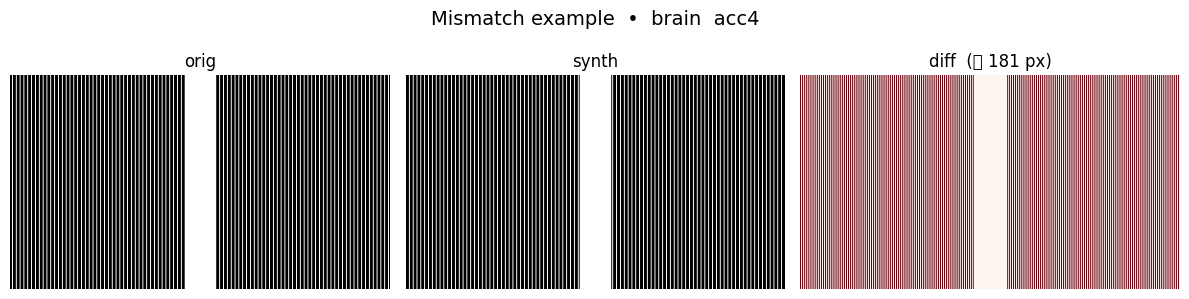

In [21]:
# --------------------- (시각화 셀 – 교체) ---------------------
first = df[df.mismatch > 0].head(1)

if first.empty:
    print("✅ 모든 파일에서 mismatch = 0   (원본과 완벽히 일치)")
else:
    p    = first.iloc[0]["path"]
    body = first.iloc[0]["body"]
    acc  = first.iloc[0]["acc"]

    orig = load_mask(p)                  # 1-D bool array
    synth, _ = synth_mask(orig, body, acc)
    diff = np.logical_xor(orig, synth)

    # ---------- 보기 좋게 세로 20배 복제 ----------
    def stretch(arr, k=20):
        return np.repeat(arr[np.newaxis, :], k, axis=0)

    fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

    ax[0].imshow(stretch(orig),  cmap="gray", aspect="auto")
    ax[0].set_title("orig");   ax[0].axis("off")

    ax[1].imshow(stretch(synth), cmap="gray", aspect="auto")
    ax[1].set_title("synth");  ax[1].axis("off")

    ax[2].imshow(stretch(diff), cmap="Reds", aspect="auto")
    ax[2].set_title(f"diff  (총 {diff.sum()} px)"); ax[2].axis("off")

    fig.suptitle(f"Mismatch example  •  {body}  acc{acc}", fontsize=14)
    plt.tight_layout(); plt.show()
